In [1]:
import ai4rgym
from ai4rgym.envs.road import Road
import gymnasium as gym
import random
from utils import ensure_dir, ensure_dirs, eval_model

import numpy as np
from scipy import linalg
from scipy import sparse
import osqp
import matplotlib.pyplot as plt

## Environment Settings:

In [15]:
# SPECIFY THE VEHCILE PARAMETERS
bicycle_model_parameters = {
    "Lf" : 0.55*2.875,
    "Lr" : 0.45*2.875,
    "m"  : 2000.0,
    "Iz" : (1.0/12.0) * 2000.0 * (4.692**2+1.850**2),
    "Cm" : (1.0/100.0) * (1.0 * 400.0 * 9.0) / 0.2286,
    "Cd" : 0.5 * 0.24 * 2.2204 * 1.202,
    "delta_offset" : 0 * np.pi/180,
    "delta_request_max" : 45 * np.pi/180,
    "Ddelta_lower_limit" : -45 * np.pi/180,
    "Ddelta_upper_limit" :  45 * np.pi/180,
    "v_transition_min": 3.0,    # v_transition_min = 3.0 m/s # kinematic model
    "v_transition_max": 5.0,    # v_transition_max = 5.0 m/s # dynamic model
    "body_len_f" : (0.55*2.875) * 1.5,
    "body_len_r" : (0.45*2.875) * 1.5,
    "body_width" : 2.50,
}

# SPECIFY THE ROAD

# This road will not be used for training / evaluation
# this is just kept in place to initialize the environment
road_elements_list = [
    {"type":"straight", "length":200.0},
    {"type":"curved", "curvature":1/250.0, "angle_in_degrees":180.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":-1/200.0, "angle_in_degrees":225.0},
    {"type":"straight", "length":40.0},
    {"type":"curved", "curvature":-1/100.0, "angle_in_degrees":320.0},
    {"type":"straight", "length":500.0}
]

# SPECIFY THE NUMERICAL INTEGRATION DETAILS
numerical_integration_parameters = {
    "method" : "rk4",
    "Ts" : 0.05,
    "num_steps_per_Ts" : 1,
}

# SPECIFY THE INITIAL STATE DISTRIBUTION (STARTING WITH KNOWN STATE!!!!!!)

# py_init_min = -1.0
# py_init_max =  1.0

# v_init_min_in_kmh = 55.0
# v_init_max_in_kmh = 65.0

py_init_min = 0.0
py_init_max =  0.0

v_init_min_in_kmh = 60.0
v_init_max_in_kmh = 60.0

initial_state_bounds = {
    "px_init_min" : 0.0,
    "px_init_max" : 0.0,
    "py_init_min" : py_init_min,
    "py_init_max" : py_init_max,
    "theta_init_min" : 0.0,
    "theta_init_max" : 0.0,
    "vx_init_min" : v_init_min_in_kmh * (1.0/3.6),
    "vx_init_max" : v_init_max_in_kmh * (1.0/3.6),
    "vy_init_min" : 0.0,
    "vy_init_max" : 0.0,
    "omega_init_min" : 0.0,
    "omega_init_max" : 0.0,
    "delta_init_min" : 0.0,
    "delta_init_max" : 0.0,
}

# SPECIFY THE TERMINATION PARAMETERS
termination_parameters = {
    "speed_lower_bound"  :  0.0,
    "speed_upper_bound"  :  (200.0/3.6),
    "distance_to_closest_point_upper_bound"  :  20.0,
    "reward_speed_lower_bound"  :  0.0,
    "reward_speed_upper_bound"  :  0.0,
    "reward_distance_to_closest_point_upper_bound"  :  0.0,
}

## Setting Observations: 

In [3]:
# SPECIFY THE OBSERVATION PARAMETERS
observation_parameters = {
    "should_include_ground_truth_px"                       :  "info",
    "should_include_ground_truth_py"                       :  "info",
    "should_include_ground_truth_theta"                    :  "info",
    "should_include_ground_truth_vx"                       :  "info",
    "should_include_ground_truth_vy"                       :  "info",
    "should_include_ground_truth_omega"                    :  "info",
    "should_include_ground_truth_delta"                    :  "info",
    "should_include_road_progress_at_closest_point"        :  "obs",
    "should_include_vx_sensor"                             :  "obs",
    "should_include_distance_to_closest_point"             :  "obs",
    "should_include_heading_angle_relative_to_line"        :  "obs",
    "should_include_heading_angular_rate_gyro"             :  "info",
    "should_include_closest_point_coords_in_body_frame"    :  "info",
    "should_include_look_ahead_line_coords_in_body_frame"  :  "info",
    "should_include_road_curvature_at_closest_point"       :  "info",
    "should_include_look_ahead_road_curvatures"            :  "info",

    "scaling_for_ground_truth_px"                       :  1.0,
    "scaling_for_ground_truth_py"                       :  1.0,
    "scaling_for_ground_truth_theta"                    :  1.0,
    "scaling_for_ground_truth_vx"                       :  1.0,
    "scaling_for_ground_truth_vy"                       :  1.0,
    "scaling_for_ground_truth_omega"                    :  1.0,
    "scaling_for_ground_truth_delta"                    :  1.0,
    "scaling_for_road_progress_at_closest_point"        :  1.0,
    "scaling_for_vx_sensor"                             :  1.0,
    "scaling_for_distance_to_closest_point"             :  1.0,
    "scaling_for_heading_angle_relative_to_line"        :  1.0,
    "scaling_for_heading_angular_rate_gyro"             :  1.0,
    "scaling_for_closest_point_coords_in_body_frame"    :  1.0,
    "scaling_for_look_ahead_line_coords_in_body_frame"  :  1.0,
    "scaling_for_road_curvature_at_closest_point"       :  1.0,
    "scaling_for_look_ahead_road_curvatures"            :  1.0,

    "vx_sensor_bias"    : 0.0,
    "vx_sensor_stddev"  : 0.1,

    "distance_to_closest_point_bias"    :  0.0,
    "distance_to_closest_point_stddev"  :  0.01,

    "heading_angle_relative_to_line_bias"    :  0.0,
    "heading_angle_relative_to_line_stddev"  :  0.01,

    "heading_angular_rate_gyro_bias"    :  0.0,
    "heading_angular_rate_gyro_stddev"  :  0.01,

    "closest_point_coords_in_body_frame_bias"    :  0.0,
    "closest_point_coords_in_body_frame_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_bias"    :  0.0,
    "look_ahead_line_coords_in_body_frame_stddev"  :  0.0,

    "road_curvature_at_closest_point_bias"    :  0.0,
    "road_curvature_at_closest_point_stddev"  :  0.0,

    "look_ahead_road_curvatures_bias"    :  0.0,
    "look_ahead_road_curvatures_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_distance"    :  100.0,
    "look_ahead_line_coords_in_body_frame_num_points"  :  10,
}

## Environment Creation:

In [16]:
class RewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(RewardWrapper, self).__init__(env)

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)

        # Create your own reward here
        reward = reward

        return observation, reward, terminated, truncated, info


def create_env(road_elements_list):
    env = gym.make(
        "ai4rgym/autonomous_driving_env",
        render_mode=None,
        bicycle_model_parameters=bicycle_model_parameters,
        road_elements_list=road_elements_list,
        numerical_integration_parameters=numerical_integration_parameters,
        termination_parameters=termination_parameters,
        initial_state_bounds=initial_state_bounds,
        observation_parameters=observation_parameters,
    )

    # Set the integration method and time step
    Ts_sim = 0.05
    integration_method = "rk4"
    env.unwrapped.set_integration_method(integration_method)
    env.unwrapped.set_integration_Ts(Ts_sim)

    # Set the road condition
    env.unwrapped.set_road_condition(road_condition="wet")

    # Rescale actions and wrap the environment
    # env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)
    # env = RewardWrapper(env)
    return env

## Domain Randomization Wrapper:

In [17]:
class DomainRandomizationWrapper(gym.Wrapper):
    def __init__(self, env, road_randomization_params=None):
        super(DomainRandomizationWrapper, self).__init__(env)
        self.road_randomization_params = road_randomization_params

    def generate_random_road_elements_list(self):
        params = self.road_randomization_params or {}
        num_elements_range = params.get('num_elements_range', (2, 5))
        straight_length_range = params.get('straight_length_range', (50.0, 200.0))
        curvature_range = params.get('curvature_range', (-1/500.0, 1/500.0))
        angle_range = params.get('angle_range', (10.0, 60.0))

        road_elements = []
        num_elements = random.randint(*num_elements_range)

        for _ in range(num_elements):
            element_type = random.choice(['straight', 'curved'])
            if element_type == 'straight':
                length = random.uniform(*straight_length_range)
                road_elements.append({"type": "straight", "length": length})
            else:
                curvature = random.uniform(*curvature_range)
                angle = random.uniform(*angle_range)
                road_elements.append({
                    "type": "curved",
                    "curvature": curvature,
                    "angle_in_degrees": angle
                })
        return road_elements

    def reset(self, **kwargs):
        # Generate a new random road
        self.unwrapped.road_elements_list = self.generate_random_road_elements_list()
        self.unwrapped.road = Road(epsilon_c=(1/10000), road_elements_list=self.unwrapped.road_elements_list)
        self.unwrapped.total_road_length = self.unwrapped.road.get_total_length()
        self.unwrapped.total_road_length_for_termination = max(self.unwrapped.total_road_length - 0.1, 0.9999 * self.unwrapped.total_road_length)
        # Call the original reset method
        return self.env.reset(**kwargs)

### Visualizing Random Roads: 

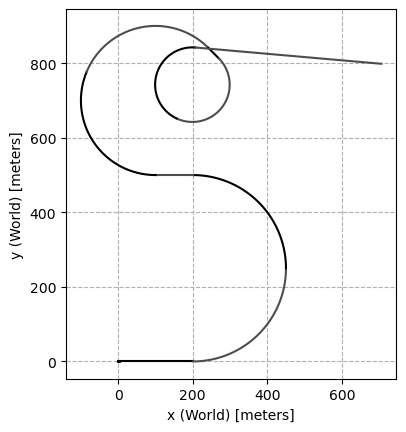

In [18]:
# Example 1: Standard Randomization
# road_randomization_params = {
#     'num_elements_range': (3, 6),          # Road will have 3 to 6 elements
#     'straight_length_range': (100.0, 150.0), # Length of straight segments between 100 and 150 meters
#     'curvature_range': (-1/300.0, 1/300.0), # Curvature between -1/300 and 1/300 for curves
#     'angle_range': (20.0, 45.0)            # Angle of the curves between 20 and 45 degrees
# }

# Example 2: More Straight Roads
road_randomization_params = {
    'num_elements_range': (2, 4),            # Fewer elements, 2 to 4
    'straight_length_range': (150.0, 300.0), # Longer straight segments between 150 and 300 meters
    'curvature_range': (-1/1000.0, 1/1000.0), # Small curvature for gentler curves
    'angle_range': (10.0, 30.0)              # Curves have lower angles between 10 and 30 degrees
}

# # Example 3: More challenging roads with Tighter curves
# road_randomization_params = {
#     'num_elements_range': (4, 8),             # More road elements
#     'straight_length_range': (50.0, 100.0),   # Shorter straight segments
#     'curvature_range': (-1/100.0, 1/100.0),   # Tighter curves
#     'angle_range': (30.0, 70.0)               # More aggressive curves with wider angle range
# }

# # Example 4: Completely Randomized
# road_randomization_params = {
#     'num_elements_range': (1, 10),             # Highly variable number of road elements
#     'straight_length_range': (50.0, 300.0),    # Straight segments can be very short or long
#     'curvature_range': (-1/50.0, 1/50.0),      # Very tight curves possible
#     'angle_range': (10.0, 90.0)                # Wide range of angles for curves
# }

random_env = create_env(road_elements_list = road_elements_list, )
# random_env = DomainRandomizationWrapper(random_env, road_randomization_params=road_randomization_params)

# Reset the random env - this will create a new random road
observation, info_dict = random_env.reset()

# Render the road
random_env.render_matplotlib_init_figure()
random_env.render_matplotlib_plot_road()
plt.show()

In [278]:
observation

{'road_progress_at_closest_point': array([0.], dtype=float32),
 'vx_sensor': array([16.640379], dtype=float32),
 'distance_to_closest_point': array([0.01385778], dtype=float32),
 'heading_angle_relative_to_line': array([0.00912378], dtype=float32)}

In [279]:
observation["road_progress_at_closest_point"][0]
observation["distance_to_closest_point"][0]
observation["heading_angle_relative_to_line"][0]

0.009123777

In [280]:
info_dict

{'ground_truth_px': array([0.], dtype=float32),
 'ground_truth_py': array([0.], dtype=float32),
 'ground_truth_theta': array([0.], dtype=float32),
 'ground_truth_vx': array([16.666666], dtype=float32),
 'ground_truth_vy': array([0.], dtype=float32),
 'ground_truth_omega': array([0.], dtype=float32),
 'ground_truth_delta': array([0.], dtype=float32),
 'heading_angular_rate_gyro': array([-0.00125492], dtype=float32),
 'closest_point_coords_in_body_frame': array([0., 0.], dtype=float32),
 'look_ahead_line_coords_in_body_frame': array([[ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
       dtype=float32),
 'road_curvature_at_closest_point': array([0.], dtype=float32),
 'look_ahead_road_curvatures': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

In [281]:
# random_env.step()

In [282]:
# Add within the class that will be created
Ts = numerical_integration_parameters["Ts"]
N = 10
n_s = 4
n_a = 2
total_sim_time = 20 # total simulation time of 20 seconds
t = 0 # current simulation time. Increments by Ts 

# initial states
p0 = 0.0
d0 = 0.0
mu0 = 0.0
v0 = 16.667 # change this to vx_sensor one observation

s0 = np.array([p0, d0, mu0, v0])
a0 = np.array([0.0, 0.0]) # F, steering angle

s0 = np.array([[p0],[d0],[mu0],[v0]])
a0 = np.array([[0.0], [0.0]]) # F, steering angle

In [317]:
def k(p_bar):
    """
    Inputs:
        p_bar  : progress along the road (m)

    Return:
        road curvature at progress p_bar (1/m)
    """
    return random_env.unwrapped.road.convert_progression_to_curvature([p_bar])[0]

In [284]:
def A_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar):
    """
    Constructs the continuous-time linearization matrix A_c.

    Inputs:
        p_bar      : progress along the road (m)
        d_bar      : orthogonal distance to road (m)
        mu_bar     : heading relative to the path (rad)
        v_bar      : velocity (m/s)
        F_bar      : drive command (%)
        delta_bar  : steering angle (rad)

    Return:
        Ac        : 4x4 numpy matrix
    """

    kappa = k(p_bar)                    # road curvature at p_bar
    Cd = bicycle_model_parameters["Cd"] # drag coefficient
    m = bicycle_model_parameters["m"]   # mass of the vehicle (kg)
    lr = bicycle_model_parameters["Lr"] # distance from rear axle to center of gravity (m)
    
    # common terms
    denom = (1 + d_bar * kappa)
    cos_mu = np.cos(mu_bar)
    sin_mu = np.sin(mu_bar)
    tan_delta = np.tan(delta_bar)
    sign_v = np.sign(v_bar)

    # A_c entries
    r0_c1 = -kappa * v_bar * cos_mu / (denom**2)
    r0_c2 = -v_bar * sin_mu / denom
    r0_c3 = cos_mu / denom

    r1_c2 = v_bar * cos_mu
    r1_c3 = sin_mu

    r2_c1 = (kappa**2) * v_bar * cos_mu / (denom**2)
    r2_c2 = kappa * v_bar * sin_mu / (denom)
    r2_c3 = (tan_delta / lr) - (kappa * cos_mu / denom)

    r3_c3 = 2 * Cd * v_bar * sign_v / m
    
    
    Ac = np.array([
        [0, r0_c1, r0_c2, r0_c3],
        [0,     0, r1_c2, r1_c3],
        [0, r2_c1, r2_c2, r2_c3],
        [0,     0,     0, r3_c3]
    ])
    
    return Ac

In [285]:
def B_c(v_bar, delta_bar):
    """
    Constructs the continuous-time linearization matrix B_c.

    Inputs:
        v_bar      : velocity (m/s)
        delta_bar  : steering angle (rad)

    Return:
        Bc        : 4x2 numpy matrix
    """

    Cm = bicycle_model_parameters["Cm"] # coefficient of something
    m = bicycle_model_parameters["m"]   # mass of the vehicle (kg)
    lr = bicycle_model_parameters["Lr"] # distance from rear axle to center of gravity (m)
    
    cos_delta = np.cos(delta_bar)

    if cos_delta == 0: # catch division by zero
        return None
    
    sec_delta = 1/cos_delta

    # B_c entries
    r2_c1 = v_bar * (sec_delta**2) / lr

    r3_c0 = Cm/m
    
    Bc = np.array([
        [0,         0],
        [0,         0],
        [0,     r2_c1],
        [r3_c0,     0]
    ])
    
    return Bc

In [286]:
def g_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar):
    """
    Constructs the continuous-time linearization matrix g_c.

    Inputs:
        p_bar      : progress along the road (m)
        d_bar      : orthogonal distance to road (m)
        mu_bar     : heading relative to the path (rad)
        v_bar      : velocity (m/s)
        F_bar      : drive command (%)
        delta_bar  : steering angle (rad)

    Return:
        gc        : 4x1 numpy matrix
    """

    kappa = k(p_bar)                    # road curvature at p_bar
    Cd = bicycle_model_parameters["Cd"] # drag coefficient
    Cm = bicycle_model_parameters["Cm"] #  coefficient
    m = bicycle_model_parameters["m"]   # mass of the vehicle (kg)
    lr = bicycle_model_parameters["Lr"] # distance from rear axle to center of gravity (m)
    
    # common terms
    denom = (1 + d_bar * kappa)
    cos_mu = np.cos(mu_bar)
    sin_mu = np.sin(mu_bar)
    tan_delta = np.tan(delta_bar)
    sign_v = np.sign(v_bar)

    # g_c entries
    r0_c0 = v_bar * cos_mu / denom
    r0_c1 = v_bar * sin_mu
    r0_c2 = (v_bar * tan_delta / lr) - (kappa * v_bar * cos_mu / denom)
    r0_c3 = (F_bar * Cm / m) - (Cd * (v_bar**2) * sign_v / m)
    
    
    term_1 = np.array([
        [r0_c0],
        [r0_c1],
        [r0_c2],
        [r0_c3]
    ])

    A_cont = A_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

    B_cont = B_c(v_bar, delta_bar)

    s = np.array([
        [p_bar],
        [d_bar],
        [mu_bar],
        [v_bar]
    ])

    a = np.array([
        [F_bar],
        [delta_bar]
    ])

    gc = term_1 - np.matmul(A_cont, s) - np.matmul(B_cont, a)
    
    return gc#.reshape(4)

In [287]:
def linearize(s, a):
    """
    Linearization of dynamics in continuous time.

    Inputs:
        s      : states, numpy array (4,1)
        a      : actions, numpy array (2,1)

    Return:
        A_lin_cont    
        B_lin_cont      
        g_lin_cont      
    """

    p_bar, d_bar, mu_bar, v_bar = s.reshape((4,))
    F_bar, delta_bar = a.reshape((2,))

    A_lin_cont = A_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

    B_lin_cont = B_c(v_bar, delta_bar)

    g_lin_cont = g_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

    return A_lin_cont, B_lin_cont, g_lin_cont 

In [288]:
def discretize(A_lin, B_lin, g_lin):
    """
    Discretization of linearized dynamics.

    Inputs:
        A_lin      : numpy array (4,4)
        B_lin      : numpy array (4,2)
        g_lin      : numpy array (4,1)

    Return:
        A_disc    
        B_disc      
        g_disc      
    """

    # Determine the number of states and actions
    n_s = A_lin.shape[1]
    n_a = B_lin.shape[1]
    n_g = g_lin.shape[1]

    # Compute the discrete time dynamics matrices
    # > Stack the matrices
    M_cont = np.vstack([ np.hstack([A_lin, B_lin, g_lin]) , np.zeros((3,n_s+n_a+n_g), dtype=np.float32) ])
    # > Compute the matrix exponential
    M_disc = linalg.expm( M_cont * Ts )
    # > Extract the matrices
    A_disc = M_disc[0:n_s,0:n_s]
    B_disc = M_disc[0:n_s,n_s:(n_s+n_a)]
    g_disc = M_disc[0:n_s,(n_s+n_a):]

    return A_disc, B_disc, g_disc

In [289]:
def dynamics_setup(s_list, a_list):
    """
    Linearize dynamics and return discretized matrices for all timesteps in the horizon

    Inputs:
        s_list      : list of states, each state is a numpy array (4,1)
        a_list      : list of actions, each action is a numpy array (2,1)

    Return:
        A_N    
        B_N      
        g_N      
    """

    A_N = []
    B_N = []
    g_N = []

    for i in range(len(a_list)): # there are N actions, and N+1 states
        A_cont, B_cont, g_cont = linearize(s_list[i], a_list[i])
        A_disc, B_disc, g_disc = discretize(A_cont, B_cont, g_cont)
        A_N.append(A_disc)
        B_N.append(B_disc)
        g_N.append(g_disc)

    return A_N, B_N, g_N

In [290]:
def dyn_init(s, a):
    """
    Constructs A_d, B_d, g_d. Only used for initialization of dynamics

    Inputs:
        s      : states, numpy array (4,1)
        a      : actions, numpy array (2,1)

    Return:
        sdot        : This only needs to be returned for the init function
        A_disc    
        B_disc      
        g_disc      
    """

    p_bar, d_bar, mu_bar, v_bar = s.reshape((4,))
    F_bar, delta_bar = a.reshape((2,))


    A_cont = A_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

    B_cont = B_c(v_bar, delta_bar)

    g_cont = g_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

    # Determine the number of states and actions
    n_s = A_cont.shape[1]
    n_a = B_cont.shape[1]
    n_g = g_cont.shape[1]

    # Compute the discrete time dynamics matrices
    # > Stack the matrices
    M_cont = np.vstack([ np.hstack([A_cont, B_cont, g_cont]) , np.zeros((3,n_s+n_a+n_g), dtype=np.float32) ])
    # > Compute the matrix exponential
    M_disc = linalg.expm( M_cont * Ts )
    # > Extract the matrices
    A_disc = M_disc[0:n_s,0:n_s]
    B_disc = M_disc[0:n_s,n_s:(n_s+n_a)]
    g_disc = M_disc[0:n_s,(n_s+n_a):]

    sdot = np.matmul(A_disc, s) + np.matmul(B_disc, a) + g_disc
    
    return sdot, A_disc, B_disc, g_disc

In [291]:
def init_construct_ABg(s, a, N):

    A_N = [] # maybe change these to np.arrays()
    B_N = []
    g_N = []
    
    states = [s]
    for n in range(N):
        sdot, A_disc, B_disc, g_disc = dyn_init(s, a)
        s = sdot
        A_N.append(A_disc)
        B_N.append(B_disc)
        g_N.append(g_disc)
        states.append(s)

    return A_N, B_N, g_N # states is never used

In [292]:
s0 = np.array([[p0],[d0],[mu0],[v0]])
a0 = np.array([[0.0], [0.0]]) # F, steering angle
A_N, B_N, g_N = init_construct_ABg(s0, a0, N)

In [293]:
def create_reference(current_time, des_speed_ms, init_speed):
    """
    Creates reference states and actions used within MPC. 
    
    *** Future update is to include the curvature to reduce speed ***

    Inputs:
        current_time      : current time of simulation
        des_speed_ms      : desired speed in m/s
        init_speed        : added to account for first mpc solve which uses different speed

    Return:
        s_ref      : list of numpy array (4,1)
        a_ref      : list of numpy array (2,1)
    """
    s_ref = []
    a_ref = []
    
    progg = current_time*des_speed_ms               # need to think about how to get progress when curves are involved!!!
    ref = np.array([[progg],[0],[0],[init_speed]])
    s_ref = [ref]
    
    a_ref.append(np.array([[0],[0]]))
    
    for n in range(1, N):

        dist = Ts*des_speed_ms 
        progg += dist
        r = np.array([[progg],[0],[0],[des_speed_ms]])
       
        s_ref.append(r)
        a_ref.append(np.array([[0],[0]]))             # presently, the reference actions are to give zero force and turn!!


    return s_ref, a_ref

In [294]:
# s_initial = np.array([[ 1.0], [ -0.5], [0.0], [-1.0]]) # NEED TO CHANGE THIS!!!!!!!!!!


# Objective matrices (CHANGE THESE VALUES!!!!!!!!!!!!)
Q = sparse.diags([5., 10., 1., 5.], format="csc", dtype=np.float32) # (progress, orthogonal distance, heading angle, velocity)
R = sparse.diags([15., 1.], format="csc", dtype=np.float32) # F, steering angle

Q_ref = np.diag([5., 10., 1., 5.]) # (progress, orthogonal distance, heading angle, velocity)
R_ref = np.diag([15., 1.])

# Q = sparse.diags([100., 0., 0., 0.], format="csc", dtype=np.float32) # (progress, orthogonal distance, heading angle, velocity)
# R = sparse.diags([0., 0.], format="csc", dtype=np.float32) # F, steering angle


# Box constraints
a_lower = np.array([[-100.0], [-45*(np.pi/180)]])
a_upper = np.array([[ 100.0], [ 45*(np.pi/180)]])

In [295]:
######################## CREATION OF AB MATRIX #########################
helper_I = np.eye(N)
result = []
for i, (A, B) in enumerate(zip(A_N, B_N)):
    AB = np.hstack([A,B])
    kron_product = np.kron(helper_I[i,:], AB)
    result.append(kron_product)

Atilde = np.vstack(result)
A_tilde = sparse.csc_matrix(Atilde, shape=(n_s*N,(n_s+n_a)*N), dtype=np.float32)

######################## CREATION OF AB MATRIX #########################

In [296]:
# Matrix for all time steps of the dynamics
negI_zero_block = sparse.hstack([ -sparse.eye(n_s,format="csc") , sparse.csc_matrix((n_s,n_a)) ])
zero_negI_col = sparse.vstack([sparse.csc_matrix(((N-1)*n_s,n_s)),-sparse.eye(n_s,format="csc")])
ABI_stacked = \
    sparse.hstack([ A_tilde , sparse.csc_matrix((N*n_s,n_s)) ]) \
    + \
    sparse.hstack([ sparse.kron(sparse.eye(N,k=1,format="csc"),negI_zero_block) , zero_negI_col ])

# Matrix for selecting the first state (I_tilde)
s0_selector = sparse.hstack([ sparse.eye(n_s,format="csc"),sparse.csc_matrix((n_s,N*(n_s+n_a))) ])

# Stacking the above two together
Aeq = sparse.vstack([ABI_stacked, s0_selector])

# Vector for equality constraint
# > Note: this vector needs to be updated every time we get a new measurement of the current state.

beq = np.vstack([np.vstack(g_N), s0])

In [297]:
# Objective function matrix
QR = sparse.block_diag([Q,R])
H  = sparse.block_diag([ sparse.kron(sparse.eye(N,format="csc"),QR), sparse.csc_matrix((n_s,n_s)) ],format="csc")

In [298]:
# Lower and upper bounds of box constraints
x_lower = np.kron(np.ones((N,1),dtype=np.float32),a_lower)
x_upper = np.kron(np.ones((N,1),dtype=np.float32),a_upper)

Ia_blocks = sparse.hstack([sparse.csc_matrix((n_a, n_s)), sparse.eye(n_a,format="csc")])
Ia = sparse.hstack([sparse.kron(sparse.eye(N, format="csc"), Ia_blocks), sparse.csc_matrix((n_a*N, n_s))])

# Build the constraint matrix for OSQP format
A_for_osqp = sparse.vstack([ Aeq , Ia ],format="csc")

# Build the constraint vectors for OSQP format
l_for_osqp = np.vstack([ beq , x_lower ])
u_for_osqp = np.vstack([ beq , x_upper ])

# Initialize an OSQP object
osqp_obj = osqp.OSQP()

In [299]:
def road_prog(speed_ms, t):
    # return distance/progress (m) assuming driving at 60km/h for t amount of time
    
    # Convert speed to m/s (1 km/h = 1000/3600 m/s)
    
    # Calculate the progress (distance) in meters
    progress = speed_ms * t

    return progress

In [300]:
ref = np.array([[p0],[0],[mu0],[v0]])
s_ref = [ref]
progg = .0
for n in range(1, N):
    des_speed_ms = 62 * (1.0/3.6)
    d = road_prog(des_speed_ms,Ts)
    progg += d
    # des_speed_ms = 0 # I set desired speed to 0 but not sure if should!!
    r = np.array([[progg],[0],[0],[des_speed_ms]])
    s_ref.append(r)
    # print(progg)

# s_ref.append(np.array([[0],[0],[0],[0]])) # this is the final state

mpc_ref = []

for i, elem in enumerate(s_ref):
        mpc_ref.append(-np.matmul(Q_ref,elem))
        mpc_ref.append(-np.matmul(R_ref,np.array([[0],[0]])))

mpc_ref.append(-np.matmul(Q_ref,np.array([[0],[0],[0],[0]]))) # this is the terminal state but do not care about it

q_input = np.vstack(mpc_ref)
q_input.shape

(64, 1)

In [301]:
s_ref

[array([[ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [16.667]]),
 array([[ 0.86111111],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 1.72222222],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 2.58333333],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 3.44444444],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 4.30555556],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 5.16666667],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 6.02777778],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 6.88888889],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]]),
 array([[ 7.75      ],
        [ 0.        ],
        [ 0.        ],
        [17.22222222]])]

In [302]:
# Setup the parameters of the optimization program
osqp_obj.setup(
    P=H, # Paul had 2*H
    q=q_input,
    A=A_for_osqp,
    l=l_for_osqp,
    u=u_for_osqp,
    verbose=False,
    #warm_starting=True,
)


In [303]:
# Solve the optimization program
osqp_result = osqp_obj.solve()

In [304]:
# Extract the status string
osqp_status_string = osqp_result.info.status

In [305]:
# Display the status if it is anything other than success
if (osqp_status_string != "solved"):
    raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

# Extract the optimal solution
x_optimal = osqp_result.x

# Extract the first action from the optimal solution
a0 = x_optimal[n_s:(n_s+n_a)]

# Extract the overall solver time
osqp_run_time = osqp_result.info.run_time

# Display some minimal information
print("OSQP successfully solved in " + str(osqp_run_time) + " seconds.")

OSQP successfully solved in 0.0016265720000000002 seconds.


In [306]:
def extract_values(optimal_vals):
    """
    Extracts the optimal state and control values from optimization problem

    Inputs:
        optimal_vals    : numpy array (64,1)

    Return:
        out_x           : list of numpy arrays (4,1)
        out_u           : list of numpy arrays (2,1)
    """
    out_x = []
    out_u = []
    for i in range(N):
        new_s = optimal_vals[i*(n_s+n_a): (i* (n_s+n_a)) + n_s].reshape((4,1))
        new_a = optimal_vals[(i*(n_s+n_a)) + n_s: (i* (n_s+n_a)) + n_s + n_a].reshape((2,1))
        out_x.append(new_s)
        out_u.append(new_a)

    new_s = optimal_vals[N*(n_s+n_a): (N* (n_s+n_a)) + n_s].reshape((4,1))
    out_x.append(new_s)

    return out_x, out_u

In [307]:
def mpc_setup():
    """
    Construct mpc problem.

    Note: This assumes that Q, R are global variables (change to class instances later)

    Inputs:

    Return:
        P_osqp    
    """

    # Objective function matrix
    QR = sparse.block_diag([Q,R])
    P_osqp  = sparse.block_diag([ sparse.kron(sparse.eye(N,format="csc"),QR), sparse.csc_matrix((n_s,n_s)) ],format="csc")

    return P_osqp

In [308]:
def mpc_update(A_N, B_N, g_N, s_ref, a_ref, s0):
    """
    Update q, A l, u for mpc problem.
    Note: This assumes that a_lower, a_upper, Q, R, Q_ref and R_ref are global variables (change to class instances later)

    TODO: Still need s0 and a0

    Inputs:
        A_N      :
        B_N      :
        g_N      :
        s_ref    :
        a_ref    : 
        s0       : numpy array (4,1)

    Return:
        q_updated    
        A_updated      
        l_updated
        u_updated      
    """

    ######################## CREATION OF AB MATRIX #########################
    helper_I = np.eye(N)
    result = []
    for i, (A, B) in enumerate(zip(A_N, B_N)):
        AB = np.hstack([A,B])
        kron_product = np.kron(helper_I[i,:], AB)
        result.append(kron_product)

    Atilde = np.vstack(result)
    A_tilde = sparse.csc_matrix(Atilde, shape=(n_s*N,(n_s+n_a)*N), dtype=np.float32)

    ######################## CREATION OF AB MATRIX #########################

    # Matrix for all time steps of the dynamics
    negI_zero_block = sparse.hstack([ -sparse.eye(n_s,format="csc") , sparse.csc_matrix((n_s,n_a)) ])
    zero_negI_col = sparse.vstack([sparse.csc_matrix(((N-1)*n_s,n_s)),-sparse.eye(n_s,format="csc")])
    ABI_stacked = \
        sparse.hstack([ A_tilde , sparse.csc_matrix((N*n_s,n_s)) ]) \
        + \
        sparse.hstack([ sparse.kron(sparse.eye(N,k=1,format="csc"),negI_zero_block) , zero_negI_col ])

    # Matrix for selecting the first state (I_tilde)
    s0_selector = sparse.hstack([ sparse.eye(n_s,format="csc"),sparse.csc_matrix((n_s,N*(n_s+n_a))) ])

    # Stacking the above two together
    Aeq = sparse.vstack([ABI_stacked, s0_selector])

    # Vector for equality constraint
    # > Note: this vector needs to be updated every time we get a new measurement of the current state.

    beq = np.vstack([np.vstack(g_N), s0])
        
    # Lower and upper bounds of box constraints
    x_lower = np.kron(np.ones((N,1),dtype=np.float32),a_lower)
    x_upper = np.kron(np.ones((N,1),dtype=np.float32),a_upper)

    Ia_blocks = sparse.hstack([sparse.csc_matrix((n_a, n_s)), sparse.eye(n_a,format="csc")])
    Ia = sparse.hstack([sparse.kron(sparse.eye(N, format="csc"), Ia_blocks), sparse.csc_matrix((n_a*N, n_s))])

    # Build the constraint matrix for OSQP format
    A_updated = sparse.vstack([ Aeq , Ia ],format="csc")

    # Build the constraint vectors for OSQP format
    l_updated = np.vstack([ beq , x_lower ])
    u_updated = np.vstack([ beq , x_upper ])

    ##################### q update #################################
    
    mpc_ref = []

    for i, elem in enumerate(s_ref):
            mpc_ref.append(-np.matmul(Q_ref,elem))
            mpc_ref.append(-np.matmul(R_ref,np.array([[0],[0]]))) #a_ref is currently zero for F and steering

    mpc_ref.append(-np.matmul(Q_ref,np.array([[0],[0],[0],[0]]))) # this is terminal state but setting everything to zero since we do not care about it

    q_updated = np.vstack(mpc_ref)

    ##################### q update #################################
    

    return q_updated, A_updated, l_updated, u_updated

In [309]:
def get_sate_observation(obs, inf):
    """
    After taking a step in environment, return the state as a vector
    
    TODO: Change the velocity to the sensor velocity

    Inputs:
        obs     : obersvations
        inf     : info dictionary

    Return:
        state observation, numpy array (4,1) 
    """
    p = obs["road_progress_at_closest_point"][0]
    d = obs["distance_to_closest_point"][0]
    mu = obs["heading_angle_relative_to_line"][0]
    v = inf["ground_truth_vx"][0]

    return np.array([[p],[d],[mu],[v]])

## MPC Simulation Loop

In [318]:
# Reset the random env - this will create a new random road
observation, info_dict = random_env.reset()

t = 0
total_sim_time = 0.2
Ts = 0.05
des_speed_ms = 60 * (1.0/3.6)
p0 = 0.
d0 = 0.
mu0 = 0.
v0 = 60 * (1.0/3.6)

trajectory = {"time":[], 
              "state":[], 
              "action":[],
              "obs": [],
              "inf":[]
              }



Q = sparse.diags([0., 0., 0., 1.], format="csc", dtype=np.float32) # (progress, orthogonal distance, heading angle, velocity)
R = sparse.diags([.5, 0.], format="csc", dtype=np.float32) # F, steering angle

Q_ref = np.diag([0., 0., 0., 1.]) # (progress, orthogonal distance, heading angle, velocity)
R_ref = np.diag([.5, 0.])




s0 = np.array([[p0],[d0],[mu0],[v0]])
a0 = np.array([[0.0], [0.0]]) # F, steering angle
A_N, B_N, g_N = init_construct_ABg(s0, a0, N)

s_ref, a_ref = create_reference(t, des_speed_ms, v0)

P_osqp = mpc_setup()
q_osqp, A_osqp, l_osqp, u_osqp = mpc_update(A_N, B_N, g_N, s_ref, a_ref, s0)

# Initialize an OSQP object
osqp_obj = osqp.OSQP()

print(A_osqp.shape)

# Setup the parameters of the optimization program
osqp_obj.setup(
    P=P_osqp,
    q=q_osqp,
    A=A_osqp,
    l=l_osqp,
    u=u_osqp,
    verbose=False,
)

# Solve the optimization program
osqp_result = osqp_obj.solve()

# Extract the status string
osqp_status_string = osqp_result.info.status

# Display the status if it is anything other than success
if (osqp_status_string != "solved"):
    raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

# Extract the optimal solution
x_optimal = osqp_result.x

# Extract the overall solver time
osqp_run_time = osqp_result.info.run_time

# Display some minimal information
print("OSQP successfully solved in " + str(osqp_run_time) + " seconds.")

s_opt, a_opt = extract_values(x_optimal)

trajectory["time"].append(t)
trajectory["action"].append(a_opt[0])
trajectory["state"].append(s0)
print(observation)
trajectory["obs"].append(observation)
trajectory["inf"].append(info_dict)

a0 = a_opt[0].reshape(2,)
# a0[0] = a0[0]/100
# a0[1] = a0[1] * (4/np.pi)

obs, _, _, _, inf = random_env.step(a0)

print(obs)


# observation, reward, terminated, truncated, info

# s_obs = get_sate_observation(obs, inf)

t+= Ts

while t < total_sim_time:

    s_obs = get_sate_observation(obs, inf)
    print("State observation: ", s_obs)
    s_list = [s_obs] + s_opt[2:]

    a_list = a_opt[1:] + [a_opt[-1]]
    
    A_N, B_N, g_N = dynamics_setup(s_list, a_list)

    s_ref, a_ref = create_reference(t, des_speed_ms, des_speed_ms) # I think this requires des_speed_ms in both inputs. Look over in future

    q_update, A_update, l_update, u_update = mpc_update(A_N, B_N, g_N, s_ref, a_ref, s_obs)


    osqp_obj.update(q=q_update,
                    l=l_update,
                    u=u_update,
                    Ax=A_update.data
                    )

    osqp_result = osqp_obj.solve()

    # Extract the status string
    osqp_status_string = osqp_result.info.status

    # Display the status if it is anything other than success
    if (osqp_status_string != "solved"):
        raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

    x_optimal = osqp_result.x

    osqp_run_time = osqp_result.info.run_time
    print("OSQP successfully solved in " + str(osqp_run_time) + " seconds.")

    s_opt, a_opt = extract_values(x_optimal)

    print("S_opt: ", s_opt)
    print("a_opt: ", a_opt)
    print("s_ref: ", s_ref)
    print("a_ref: ", a_ref)

    trajectory["time"].append(t)
    trajectory["action"].append(a_opt[0])
    trajectory["state"].append(s_obs)
    trajectory["obs"].append(obs)
    trajectory["inf"].append(inf)

    a0 = a_opt[0].reshape(2,)
    # a0[0] = a0[0]/100
    # a0[1] = a0[1] * (4/np.pi)

    obs, _, _, _, inf = random_env.step(a0)

    t+= Ts

(64, 64)
OSQP successfully solved in 0.000960209 seconds.
{'road_progress_at_closest_point': array([0.], dtype=float32), 'vx_sensor': array([16.68491], dtype=float32), 'distance_to_closest_point': array([-0.00152503], dtype=float32), 'heading_angle_relative_to_line': array([-0.00307981], dtype=float32)}
{'road_progress_at_closest_point': array([0.83327734], dtype=float32), 'vx_sensor': array([16.496126], dtype=float32), 'distance_to_closest_point': array([-0.00089034], dtype=float32), 'heading_angle_relative_to_line': array([-0.00289106], dtype=float32)}
State observation:  [[ 8.3327734e-01]
 [-8.9033687e-04]
 [-2.8910607e-03]
 [ 1.6664427e+01]]
OSQP successfully solved in 0.000110719 seconds.
S_opt:  [array([[ 8.33293775e-01],
       [-8.90336874e-04],
       [-2.89106067e-03],
       [-1.15267217e+05]]), array([[ 1.43297985e+08],
       [ 5.13429038e-03],
       [-2.40888189e-03],
       [ 1.65588094e+03]]), array([[-3.84477761e+07],
       [-4.28687191e-03],
       [ 2.40888578e-03]

ValueError: OSQP did not solve the problem, returned status = dual infeasible

In [270]:
trajectory["obs"]

[{'road_progress_at_closest_point': array([1.6566015], dtype=float32),
  'vx_sensor': array([16.259277], dtype=float32),
  'distance_to_closest_point': array([-0.00478384], dtype=float32),
  'heading_angle_relative_to_line': array([0.00295084], dtype=float32)},
 {'road_progress_at_closest_point': array([1.6566015], dtype=float32),
  'vx_sensor': array([16.259277], dtype=float32),
  'distance_to_closest_point': array([-0.00478384], dtype=float32),
  'heading_angle_relative_to_line': array([0.00295084], dtype=float32)}]

In [213]:
trajectory["action"]

[array([[-2.03647588e-05],
        [ 0.00000000e+00]]),
 array([[ 1.83932525e+02],
        [-2.15127845e-06]])]

In [185]:

s_opt, a_opt = extract_values(x_optimal)
a0 = a_opt[0]

In [186]:
a0[0]

array([1.61713945])

In [162]:
random_env.step(a_opt[0].reshape(2,1))

array([[0.00635081],
       [0.        ]])